# Variational Autoencoder

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

!pip install numpy_indexed

%load_ext autoreload
%autoreload 2

## Device configuration and setting Google Colab

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
bs = 32

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/')

Mounted at /content/gdrive


## Load images

In [ ]:
# load all images in a directory
from os import listdir
from matplotlib import image
from skimage.io import imread
from skimage.transform import resize
import cv2

drive_path = '/content/gdrive/MyDrive/DTU/Deep learning/Deep_learning_Project/segmentation_data/segmented_images/COPSAC_segmented/'

# load all images in a directory
loaded_images = list()
images_filename=[]
list_patients =  listdir(drive_path)[5:150]#list_patients_w_gluc[5:110]#["68","303"] # # list_patients_w_gluc[10:15]
size_images=120

for patient in list_patients:
  for filename in listdir(drive_path+patient+'/'):
    image_cv2 = cv2.imread(drive_path+patient+'/'+filename)
    new_image = resize(image_cv2, output_shape=(size_images, size_images), mode='reflect', anti_aliasing=True)

    loaded_images.append(new_image)
    images_filename.append(filename+"_"+patient)

print("loaded images: ", len(loaded_images))
print("loaded images filenames: ", images_filename)

loaded images:  6350
loaded images filenames:  ['IMG_0207.jpg_169', 'IMG_0346.jpg_169', 'IMG_0347.jpg_169', 'IMG_0352.jpg_169', 'IMG_0343.jpg_169', 'IMG_0335.jpg_169', 'IMG_0217.jpg_169', 'Scanned_20170930-1526.jpg_62', 'Scanned_20170930-1525.jpg_62', 'Scanned_20170930-1531.jpg_62', 'IMG_9714.JPG_130', 'IMG_9697.JPG_130', 'IMG_9771.JPG_130', 'IMG_9696.JPG_130', 'IMG_9716.JPG_130', 'IMG_9731.JPG_130', 'IMG_9730.JPG_130', 'IMG_9708.JPG_130', 'IMG_9736.JPG_130', 'IMG_9712.JPG_130', 'IMG_9721.JPG_130', 'IMG_9752.JPG_130', 'IMG_9765.JPG_130', 'IMG_9693.JPG_130', 'IMG_9695.JPG_130', 'IMG_9713.JPG_130', 'IMG_9694.JPG_130', 'IMG_9698.JPG_130', 'IMG_9707.JPG_130', '20190506_182748.jpg_17', '20190508_185437.jpg_17', '20190509_185927.jpg_17', '20190501_094206.jpg_17', '20190507_192128.jpg_17', '20190502_140220.jpg_17', '20190501_212902.jpg_17', '20190501_112220.jpg_17', '20190430_181158.jpg_17', '20190502_191621.jpg_17', '20190501_065625.jpg_17', '20190504_191916.jpg_17', 'IMG_0372.jpg_124', 'IMG

In [ ]:
import random
import numpy_indexed as npi
import numpy as np
from torch.utils.data import DataLoader

#check duplicated images
indices = npi.group_by(loaded_images).split(np.arange(len(loaded_images)))

np.shape(np.unique(loaded_images,axis=0))

#we keep only unique images
loaded_images=np.unique(loaded_images,axis=0)
#loaded_images=loaded_images*255
# Split into train and test
from sklearn.model_selection import train_test_split
dset_train, dset_test = train_test_split(loaded_images, test_size=0.2, random_state=1)

batch_size = 128
eval_batch_size = 256

# The loaders perform the actual work
dataloader = DataLoader(dset_train, batch_size=batch_size) #,sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size) #,sampler=stratified_sampler(dset_test.test_labels))

In [ ]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataloader)

40

## Model

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 5, 5)

In [ ]:
fixed_x = next(iter(dataloader))

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=6400, z_dim=256):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride = 2),
            nn.ReLU(),         
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        x=x.permute(0,3,1,2)
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        z = z.permute(0,3,2,1)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        latent = z
        z = self.decode(z)
        return latent, z, mu, logvar

In [ ]:
image_channels = fixed_x.size(3)

In [ ]:
model = VAE(image_channels=image_channels).to(device)
#model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    recon_x_clean = recon_x.detach().clone()
    recon_x_clean[x == 0] = 0
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

## Training the model

In [ ]:
epochs = 25

In [ ]:
import matplotlib.pyplot as plt

loss_batch=[]
bce_batch=[]
kld_batch=[]
loss_batch_mean=np.zeros((epochs))
bce_batch_mean=np.zeros((epochs))
kld_batch_mean=np.zeros((epochs))

for epoch in range(epochs):
    for idx, images in enumerate(dataloader):
        images = images.type(torch.FloatTensor) # Byte to Float
        images = images.to(device,dtype=torch.float)
        n_images_in_batch=images.size()[0]

        latent, recon_images, mu, logvar = model(images)
        z = recon_images.cpu().detach().numpy()
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

        loss_batch.append(loss.data/n_images_in_batch)
        bce_batch.append(bce.data/n_images_in_batch) 
        kld_batch.append(kld.data/n_images_in_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                        epochs, loss.data/n_images_in_batch, bce.data/n_images_in_batch, kld.data/n_images_in_batch)

    print("epoch ", epoch)
    loss_batch_mean[epoch]=np.mean(loss_batch)
    bce_batch_mean[epoch]=np.mean(bce_batch)
    kld_batch_mean[epoch]=np.mean(kld_batch)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24


Text(0.5, 0, 'epoch')

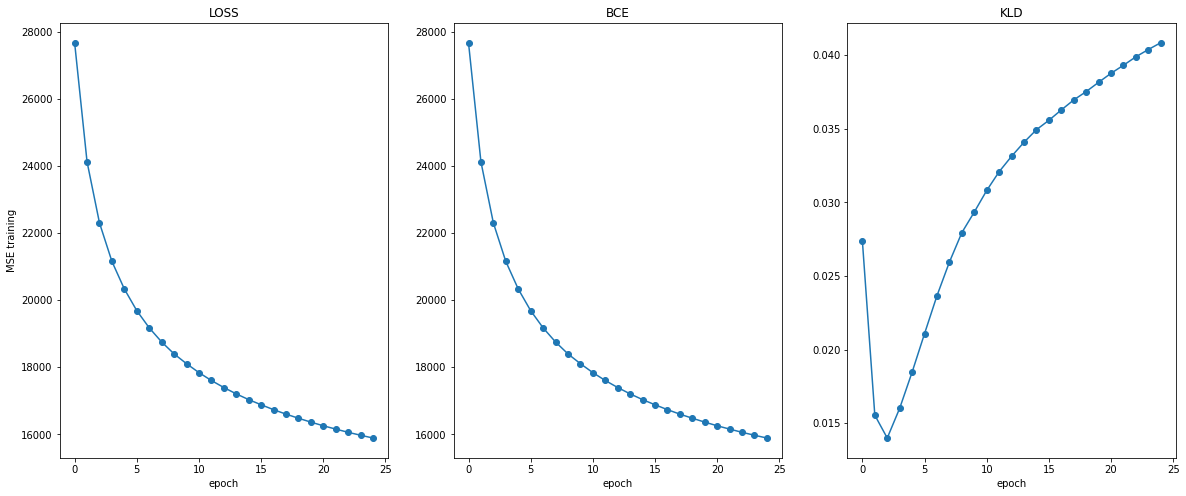

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (20, 8))
ax1.plot(loss_batch_mean,"-o")
ax2.plot(bce_batch_mean,"-o")
ax3.plot(kld_batch_mean,"-o")

ax1.set_title("LOSS")
ax1.set_xlabel("epoch")
ax1.set_ylabel("MSE training")
ax2.set_title("BCE")
ax2.set_xlabel("epoch")
ax3.set_title("KLD")
ax3.set_xlabel("epoch")

## Evaluation of the reconstruction

In [ ]:
def compare(x):
    _, recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

Original image:


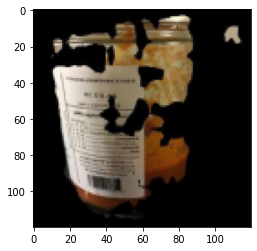

In [ ]:
import cv2

fixed_x1 = next(iter(test_loader))
fixed_x1 = fixed_x1.type(torch.FloatTensor) # Byte to Float
fixed_x1 = fixed_x1.to(device,dtype=torch.float)

latent, recon_x, _, _ = model(fixed_x1)
#recon_x, _, _ = model(fixed_x1)
print("Original image:")
plt.imshow(cv2.cvtColor(np.float32(fixed_x1[10]), cv2.COLOR_BGR2RGB))

Reconstructed image:


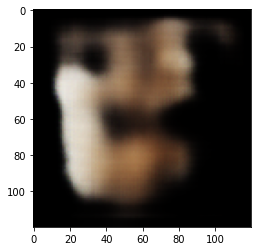

In [ ]:
print("Reconstructed image:")
plt.imshow(cv2.cvtColor(np.float32(recon_x[10].data.cpu()), cv2.COLOR_BGR2RGB))

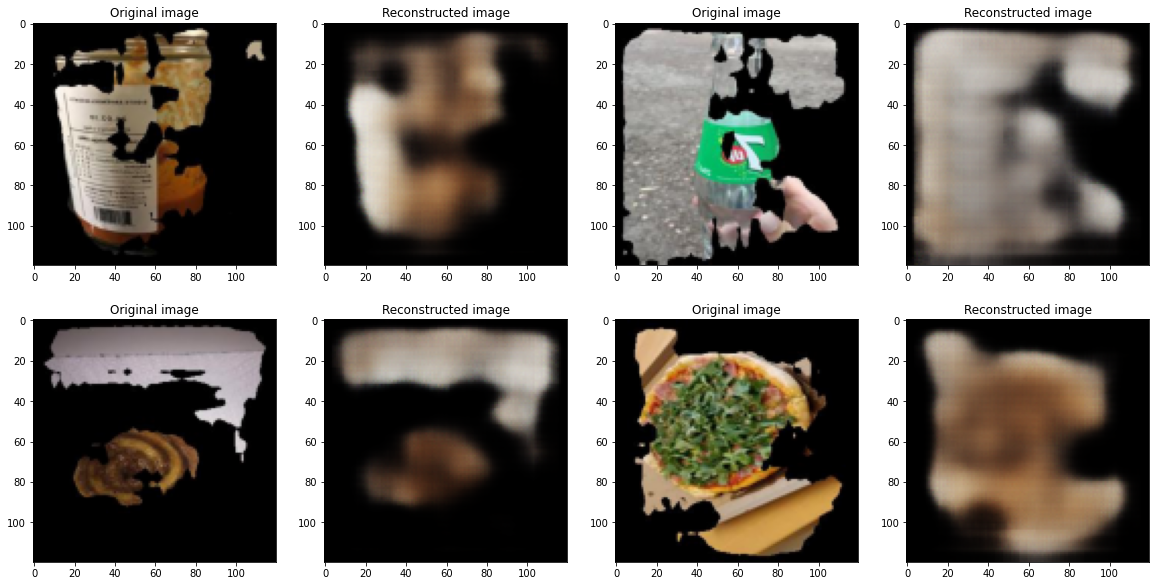

In [ ]:
# plot reconstructions

fig, axes = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)

axes[0, 0].set_title(r'Original image')
axes[0, 0].imshow(cv2.cvtColor(np.float32(fixed_x1[10]), cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(r'Reconstructed image')
axes[0, 1].imshow(cv2.cvtColor(np.float32(recon_x[10].data.cpu()), cv2.COLOR_BGR2RGB))
axes[1, 0].set_title(r'Original image')
axes[1, 0].imshow(cv2.cvtColor(np.float32(fixed_x1[9]), cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(r'Reconstructed image')
axes[1, 1].imshow(cv2.cvtColor(np.float32(recon_x[9].data.cpu()), cv2.COLOR_BGR2RGB))
axes[0, 2].set_title(r'Original image')
axes[0, 2].imshow(cv2.cvtColor(np.float32(fixed_x1[8]), cv2.COLOR_BGR2RGB))
axes[0, 3].set_title(r'Reconstructed image')
axes[0, 3].imshow(cv2.cvtColor(np.float32(recon_x[8].data.cpu()), cv2.COLOR_BGR2RGB))
axes[1, 2].set_title(r'Original image')
axes[1, 2].imshow(cv2.cvtColor(np.float32(fixed_x1[7]), cv2.COLOR_BGR2RGB))
axes[1, 3].set_title(r'Reconstructed image')
axes[1, 3].imshow(cv2.cvtColor(np.float32(recon_x[7].data.cpu()), cv2.COLOR_BGR2RGB))

## Evaluation of the latent space

torch.Size([256, 256])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


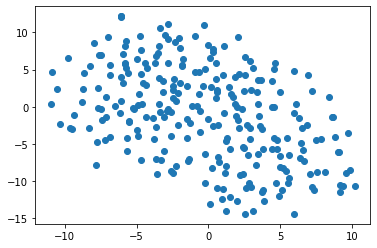

In [ ]:
print(latent.shape)

from sklearn.manifold import TSNE

z = TSNE(n_components=2).fit_transform(latent.detach().numpy())
plt.scatter(z[:, 0], z[:, 1])#, color=colors)
plt.show()

## Evaluation of the K-means clustering

Cluster  0  :


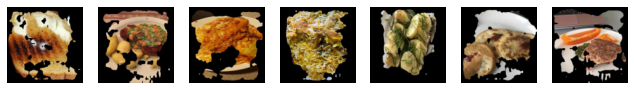

Cluster  1  :


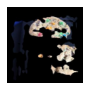

Cluster  2  :


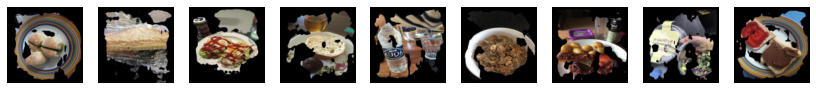

Cluster  3  :


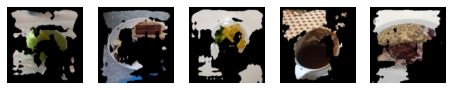

Cluster  4  :


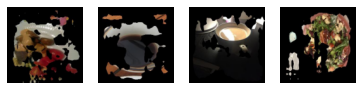

Cluster  5  :


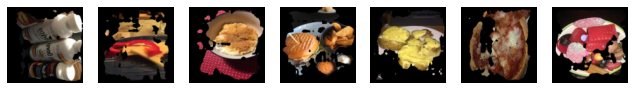

Cluster  6  :


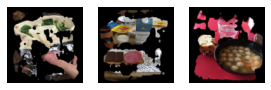

Cluster  7  :


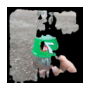

Cluster  8  :


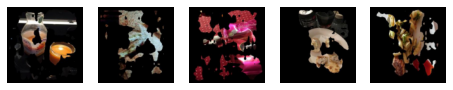

Cluster  9  :


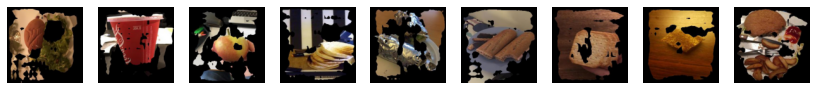

Cluster  10  :


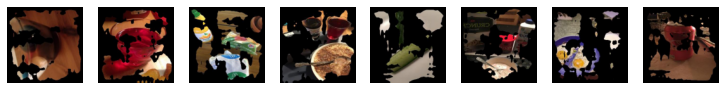

Cluster  11  :


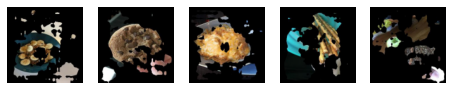

Cluster  12  :


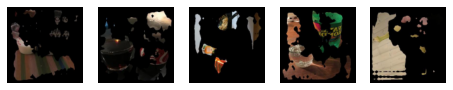

Cluster  13  :


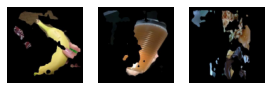

Cluster  14  :


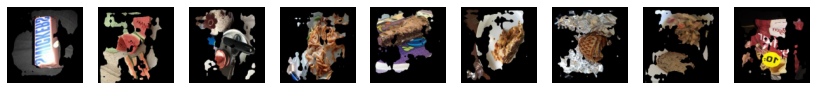

Cluster  15  :


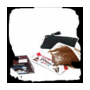

Cluster  16  :


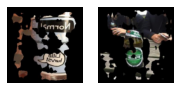

Cluster  17  :


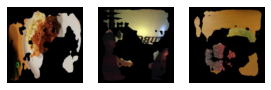

Cluster  18  :


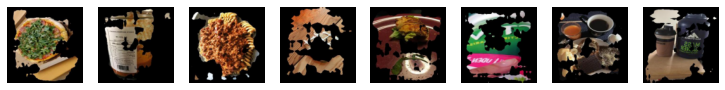

Cluster  19  :


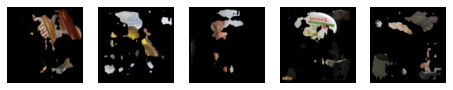

Cluster  20  :


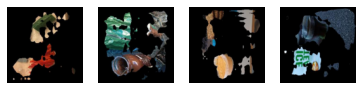

Cluster  21  :


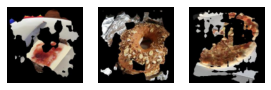

Cluster  22  :


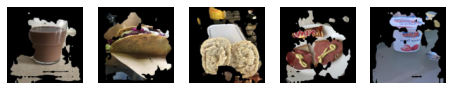

Cluster  23  :


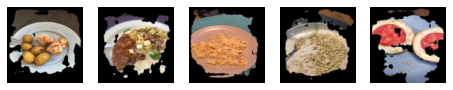

Cluster  24  :


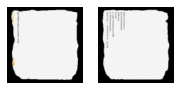

Cluster  25  :


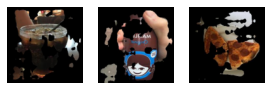

Cluster  26  :


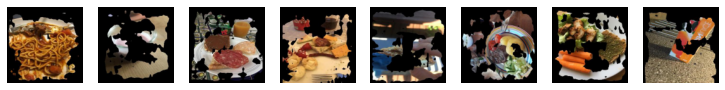

Cluster  27  :


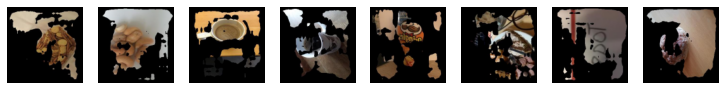

Cluster  28  :


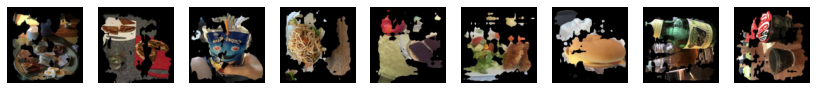

Cluster  29  :


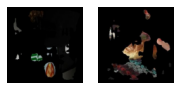

Cluster  30  :


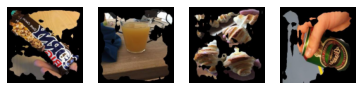

Cluster  31  :


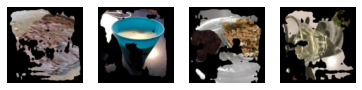

Cluster  32  :


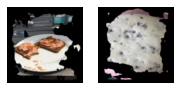

Cluster  33  :


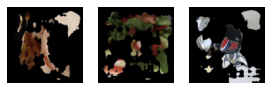

Cluster  34  :


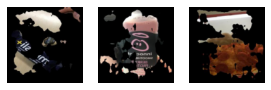

Cluster  35  :


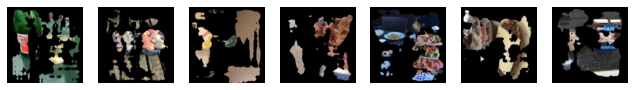

Cluster  36  :


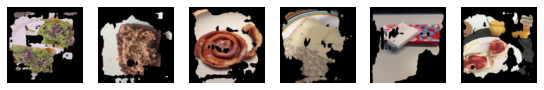

Cluster  37  :


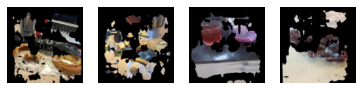

Cluster  38  :


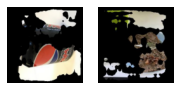

Cluster  39  :


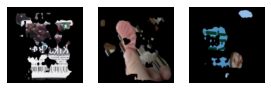

Cluster  40  :


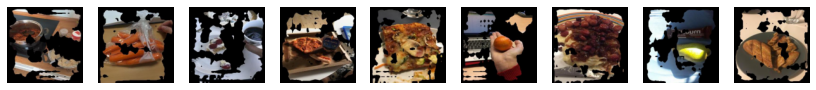

Cluster  41  :


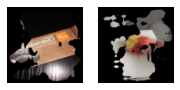

Cluster  42  :


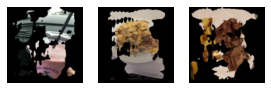

Cluster  43  :


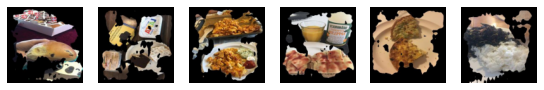

Cluster  44  :


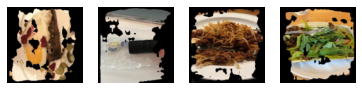

Cluster  45  :


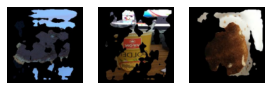

Cluster  46  :


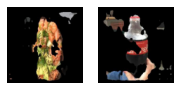

Cluster  47  :


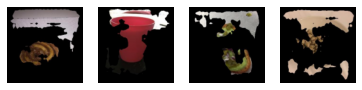

Cluster  48  :


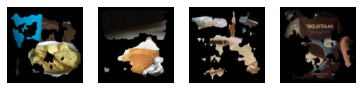

Cluster  49  :


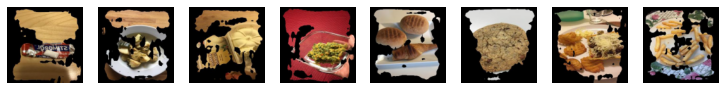

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(latent.detach().numpy())
kmeans.labels_

#plt.imshow(x[4].cpu().detach().numpy())

def plot_cluster(klabels,k,image,n_images=10):
  idx_k = klabels == k
  image_k = image[idx_k][:, :, :,[2, 1, 0]] # cv2.cvtColor(image[idx_k], cv2.COLOR_BGR2RGB) # 
  fig = plt.figure(figsize=(16,10))   

  for idx in range(n_images-1):
      if idx >= image_k.size(0):
        break
      else:
        ax = fig.add_subplot(1, n_images, idx+1) # this line adds sub-axes
        ax.imshow(image_k.cpu()[idx]) # this line creates the image using the pre-defined sub axes
        ax.axis('off')

for i in range(n_clusters):
  print("Cluster ", i, " :")      
  plot_cluster(kmeans.labels_,i,fixed_x1)
  plt.show()